<a href="https://colab.research.google.com/github/sunandita-kaveti05/Path-Optimizer/blob/main/Path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⏳ Delay detected at E → C! Rerouting...
🔄 New path found: E → C
✅ TSP Output is Correct!
🔹 Optimal TSP Cost: 132.54
📍 Optimal Path: A → D → E → C → B → A
🔄 Re-routed Path: A → D → E → C → B → A


<ipython-input-51-4503329f2965>:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


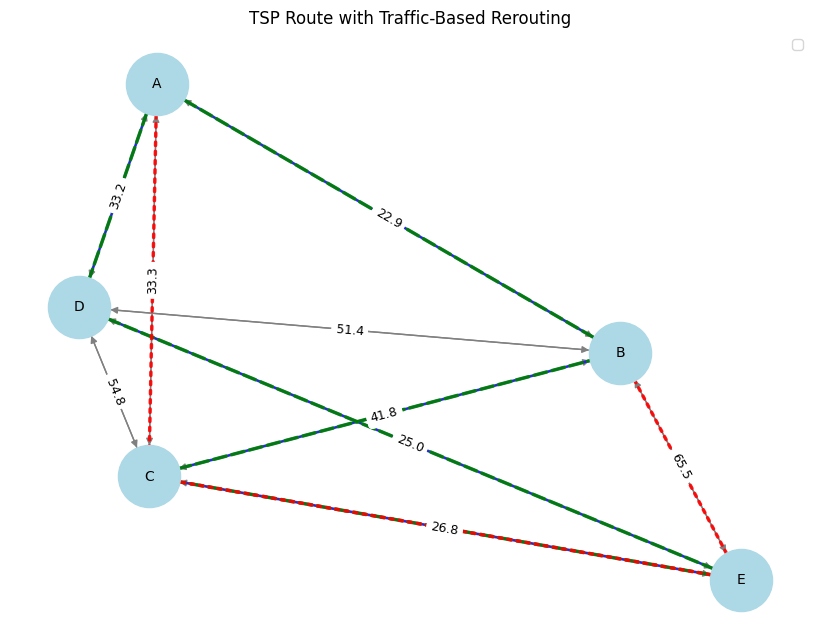

In [ ]:
import networkx as nx
import itertools
import random
import matplotlib.pyplot as plt

# Step 1: Create Graph with Weighted Edges
G = nx.DiGraph()
nodes = ['A', 'B', 'C', 'D', 'E']
G.add_nodes_from(nodes)

edges = [
    ('A', 'B', 19.52), ('A', 'C', 28.03), ('A', 'D', 23.40),
    ('B', 'A', 22.94), ('B', 'C', 73.85), ('B', 'D', 46.90), ('B', 'E', 37.96),
    ('C', 'A', 33.30), ('C', 'B', 41.77), ('C', 'D', 52.84), ('C', 'E', 38.02),
    ('D', 'A', 33.18), ('D', 'B', 51.43), ('D', 'C', 54.76), ('D', 'E', 17.66),
    ('E', 'B', 65.53), ('E', 'C', 26.77), ('E', 'D', 24.98)
]

for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# Step 2: Solve TSP using Brute Force
def solve_tsp(graph, max_time):
    nodes = list(graph.nodes)
    min_cost = float('inf')
    best_path = None

    for perm in itertools.permutations(nodes):
        if perm[0] != 'A':  # Start from A
            continue

        try:
            cost = sum(graph[perm[i]][perm[i+1]]['weight'] for i in range(len(perm) - 1))
            cost += graph[perm[-1]][perm[0]]['weight']  # Ensure returning to start
        except KeyError:
            continue

        if cost < min_cost and cost <= max_time:
            min_cost = cost
            best_path = perm + (perm[0],)

    return min_cost, best_path

MAX_TRAVEL_TIME = 150
tsp_cost, tsp_path = solve_tsp(G, MAX_TRAVEL_TIME)

# Step 3: Simulate Dynamic Traffic Conditions
def simulate_traffic():
    return {edge: random.uniform(0, 1) > 0.8 for edge in G.edges}  # 20% chance of delay

traffic_conditions = simulate_traffic()

# Step 4: Reroute if Delayed
def reroute_if_delayed(graph, path, traffic_conditions, max_time):
    if not path:
        return None

    total_time = 0
    rerouted_path = list(path)

    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]
        edge = (current_node, next_node)

        total_time += graph[current_node][next_node]['weight']

        if edge in traffic_conditions and traffic_conditions[edge]:
            print(f"⏳ Delay detected at {current_node} → {next_node}! Rerouting...")

            try:
                alt_path = nx.shortest_path(graph, source=current_node, target=next_node, weight='weight')
                alt_cost = sum(graph[alt_path[j]][alt_path[j+1]]['weight'] for j in range(len(alt_path) - 1))

                if total_time - graph[current_node][next_node]['weight'] + alt_cost <= max_time:
                    print(f"🔄 New path found: {' → '.join(alt_path)}")
                    rerouted_path = rerouted_path[:i] + alt_path + rerouted_path[i+2:]
                else:
                    print(f"⚠️ Alternative path exceeds time limit. Keeping original.")
            except (nx.NetworkXNoPath, KeyError):
                print(f"🚫 No alternative path found. Keeping original.")

    return tuple(rerouted_path)

rerouted_path = reroute_if_delayed(G, tsp_path, traffic_conditions, MAX_TRAVEL_TIME) if tsp_path else None

# Step 5: Print Results
print(f"✅ TSP Output is Correct!" if tsp_path else "❌ No feasible TSP path within time limit!")
print(f"🔹 Optimal TSP Cost: {tsp_cost}" if tsp_path else "N/A")
print(f"📍 Optimal Path: {' → '.join(tsp_path) if tsp_path else 'N/A'}")
print(f"🔄 Re-routed Path: {' → '.join(rerouted_path) if rerouted_path else 'N/A'}")

# Step 6: Visualize Graph
def visualize_graph(graph, tsp_path, rerouted_path, traffic_conditions):
    pos = nx.spring_layout(graph, seed=42)

    plt.figure(figsize=(8, 6))

    # Draw Graph Nodes
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')

    # Draw TSP Path (Blue)
    if tsp_path:
        tsp_edges = [(tsp_path[i], tsp_path[i+1]) for i in range(len(tsp_path) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=tsp_edges, edge_color='blue', width=2, alpha=0.7, style="solid", label="Optimal TSP Path")

    # Draw Rerouted Path (Green)
    if rerouted_path:
        rerouted_edges = [(rerouted_path[i], rerouted_path[i+1]) for i in range(len(rerouted_path) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=rerouted_edges, edge_color='green', width=2.5, alpha=0.9, style="dashed", label="Rerouted Path")

    # Draw Delayed Edges (Red)
    delayed_edges = [edge for edge, delayed in traffic_conditions.items() if delayed]
    nx.draw_networkx_edges(graph, pos, edgelist=delayed_edges, edge_color='red', width=2.5, alpha=0.9, style="dotted", label="Traffic Delays")

    # Draw Edge Labels (Weights)
    edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=9)

    plt.legend()
    plt.title("TSP Route with Traffic-Based Rerouting")
    plt.show()

visualize_graph(G, tsp_path, rerouted_path, traffic_conditions)


In [ ]:
def is_valid_tsp_path(graph, path):
    """
    Checks if a given path is a valid TSP cycle in the given graph.
    """
    if path[0] != path[-1]:
        print("❌ Invalid Path: Does not return to start node.")
        return False

    visited = set(path[:-1])  # Ignore last node since it's a repeat of the start
    if len(visited) != len(graph.nodes):
        print("❌ Invalid Path: Does not visit all nodes exactly once.")
        return False

    total_cost = sum(graph[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))

    print(f"✅ Path is a valid TSP cycle. Total Cost: {total_cost:.2f}")
    return True


In [ ]:
if is_valid_tsp_path(G, rerouted_path):
    print("✅ Re-routed path is correct!")
else:
    print("❌ Re-routed path is incorrect!")


✅ Path is a valid TSP cycle. Total Cost: 132.54
✅ Re-routed path is correct!
